Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


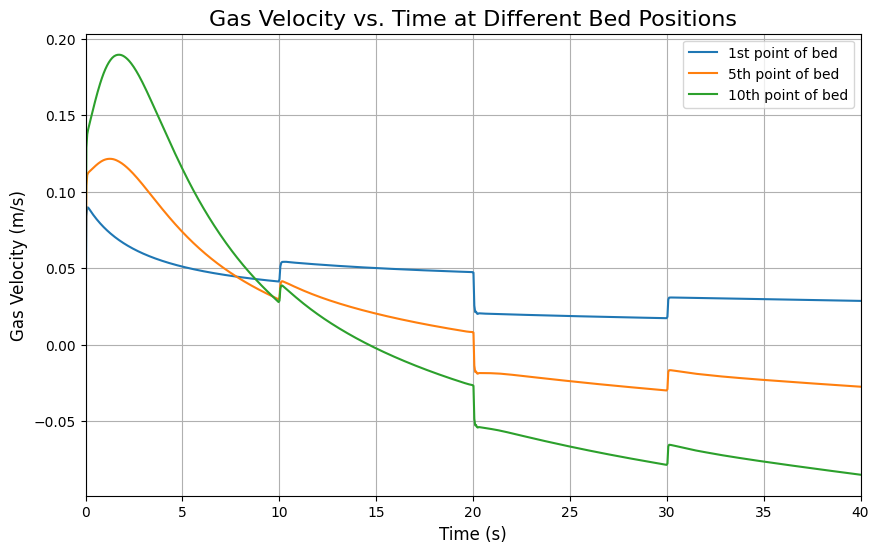

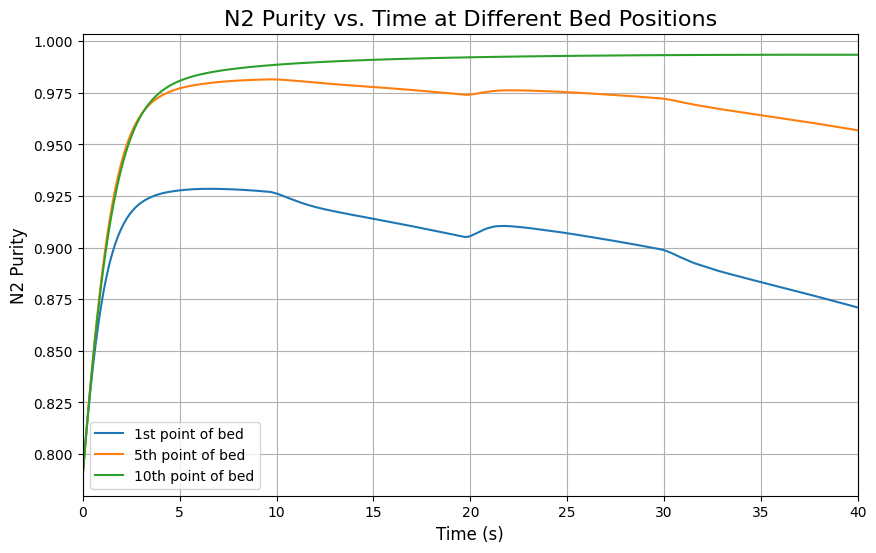

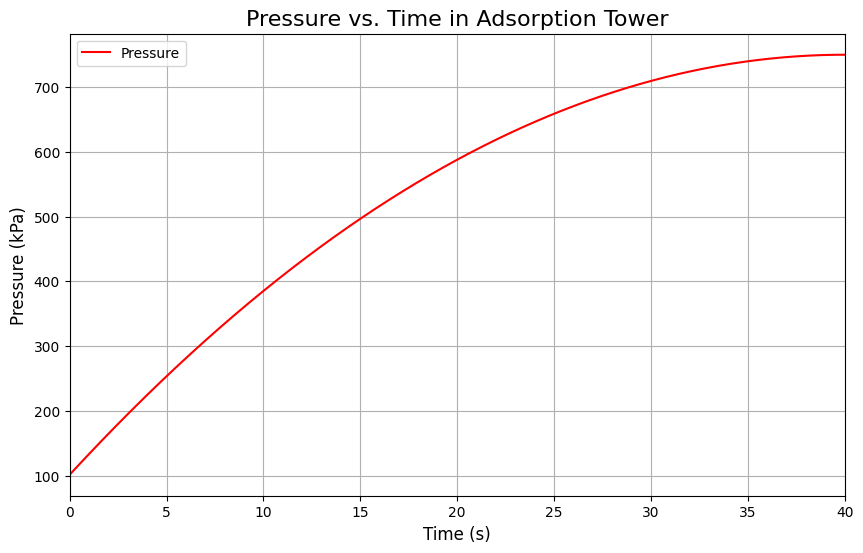

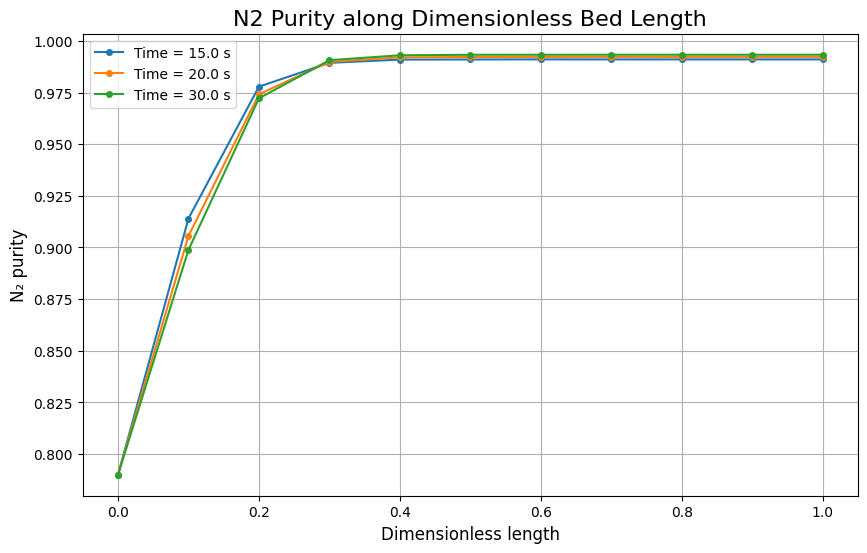

In [6]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from google.colab import drive
import sys
from scipy.interpolate import interp1d
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/modelling'
sys.path.append(file_path)
import compressor
L = 2.00   # m
P_H = 750000
P_L = 101325   # pa
T = 300.15;
t_adsorption = 40 # s
epsilon = 0.4;
D_L = 9e-7;      # m^2/s
R_g = 8.314

k_A = 0.0832; k_B = 0.00468      # s^-1
K_A = 9.35; K_B = 9.35
ohmn_A = 47; ohmn_B = 40
y_A_in = 0.21; y_B_in = 0.79
D_dcm_a = 1.77e-3
D_dcm_b = 1.17e-4

v_g_in_data = compressor.compressor_outlet   # m/s



matrix_A = np.array([
    [-9.1602, 14.96, -10.336, 8.3222, -7.0296, 6.0402, -5.1923, 4.3967, -3.5791, 2.632, -1.0543],
    [-2.9225, -4.0248, 10.913, -6.9352, 5.3886, -4.4499, 3.7429, -3.1292, 2.528, -1.8512, 0.74031],
    [0.88657, -4.7918, -2.6072, 9.9843, -5.9667, 4.4664, -3.5791, 2.9127, -2.3168, 1.6823, -0.67052],
    [-0.43165, 1.8414, -6.0373, -1.9568, 9.9317, -5.6682, 4.0959, -3.1667, 2.4498, -1.753, 0.69475],
    [0.26641, -1.0454, 2.6363, -7.257, -1.5918, 10.418, -5.7238, 3.9871, -2.933, 2.0468, -0.80363],
    [-0.19229, 0.72519, -1.6577, 3.479, -8.7513, -1.365, 11.448, -6.0685, 4.0333, -2.6903, 1.0394],
    [0.15681, -0.57866, 1.2602, -2.3849, 4.5612, -10.86, -1.2163, 13.232, -6.7274, 4.0901, -1.5331],
    [-0.14276, 0.52014, -1.1026, 1.9825, -3.4161, 6.1897, -14.227, -1.1174, 16.312, -7.6987, 2.7006],
    [0.14633, -0.52909, 1.1043, -1.9311, 3.1641, -5.1796, 9.1072, -20.538, -1.0531, 22.03, -6.3204],
    [-0.17802, 0.64096, -1.3265, 2.2859, -3.6528, 5.7158, -9.16, 16.036, -36.445, -1.0154, 27.099],
    [0.42424, -1.5249, 3.1455, -5.3899, 8.5325, -13.137, 20.427, -33.466, 62.207, -161.22, 120]
])


matrix_B = np.array([
    [-23.43, -5.8982, 61.295, -61.652, 56.372, -50.304, 44.148, -37.841, 31.029, -22.91, 9.1916],
    [70.069, -144.95, 83.106, -6.6484, -5.6013, 8.5995, -9.0083, 8.3874, -7.1837, 5.4251, -2.1954],
    [-12.372, 98.598, -177.83, 108.28, -21.426, 5.9422, -1.0519, -0.7598, 1.33, -1.2495, 0.54203],
    [4.3848, -22.477, 120.02, -211.98, 132.66, -30.953, 12.171, -5.7949, 3.0242, -1.6252, 0.56268],
    [-2.1733, 9.5551, -30.959, 148.17, -262.28, 167.64, -42.018, 18.31, -9.8658, 5.6814, -2.0566],
    [1.3362, -5.4638, 14.731, -41.745, 192.42, -345.15, 225.38, -59.019, 26.879, -14.526, 5.1562],
    [-0.96735, 3.8021, -9.3693, 21.81, -58.871, 269.78, -495.39, 331.94, -89.812, 40.772, -13.694],
    [0.80723, -3.1, 7.2688, -15.363, 33.914, -90.774, 423.24, -808.55, 561.48, -154.48, 45.56],
    [-0.96735, 2.9497, -6.7215, 13.485, -27.033, 59.36, -162.81, 796.07, -1639.6, 1202.6, -237.59],
    [0.91276, -3.431, 7.6977, -15.026, 28.721, -57.778, 132.03, -390.11, 2140.3, -5370.9, 3527.5],
    [100.52, -361.01, 743.31, -1269.8, 2000, -3052.7, 4670.8, -7392.8, 12460, -17378, 9480]
])



N_z = 11   # lattice point
dz = L / (N_z-1) # lattice space
a_shape = 2.0 #



def psa_full_ode_system(t, state, P, dP_dt,get_v_g_t):


    y_A = state[0 * N_z : 1 * N_z]
    q_A = state[1 * N_z : 2 * N_z]
    q_B = state[2 * N_z : 3 * N_z]

    y_A[0] = 0.21



    y_B = 1-y_A


    const_q_star = P / (R_g * T)
    q_star_A = K_A * y_A * const_q_star
    q_star_B = K_B * y_B * const_q_star
    dq_A_dt = k_A * (q_star_A - q_A)          # LDF_A
    dq_B_dt = k_B * (q_star_B - q_B)          # LDF_B

    dq_A_dt[0] = 0
    dq_B_dt[0] = 0


    v_g = np.full(N_z, get_v_g_t)

    const_v = (1 - epsilon) / epsilon * (R_g * T / P)
    pressure_term_v = (1 / P) * dP_dt

    for j in range(N_z - 1):
        dv_g_dz = -(const_v * (dq_A_dt[j] + dq_B_dt[j]) - pressure_term_v)

        v_g[j+1] = v_g[j] + dv_g_dz * dz     # speed of gas


    dispersion_term_A = (D_L / a_shape**2) * (matrix_B @ y_A)
    convection_term_A = -(v_g / a_shape) * (matrix_A @ y_A)
                           # boundary condition   appendix (51)

    convection_term_A[-1] = 0
    convection_term_A[0] = 0

    adsorption_term_A = ((1 - epsilon) / epsilon) * (R_g * T / P) * ((y_A - 1) * dq_A_dt + y_A * dq_B_dt)

    pressure_term_A = (y_A / P) * dP_dt

    dy_A_dt = dispersion_term_A + convection_term_A + adsorption_term_A + pressure_term_A   # dy_A/dt
    dy_A_dt[0] = -(get_v_g_t / D_L) * (y_A[0] - y_A[0])

    d_state_dt = np.concatenate((dy_A_dt, dq_A_dt, dq_B_dt))
    #print("a",q_A,"b",q_B, "y_A",y_A,"y_B",y_B)

    return d_state_dt





y_A_initial = np.full(N_z, y_A_in)

q_A_initial = np.zeros(N_z)
q_B_initial = np.zeros(N_z)
initial_state = np.concatenate((y_A_initial, q_A_initial, q_B_initial))

dt = 900

# time
t_span = [0, 40]
t_eval = np.linspace(t_span[0], t_span[1], dt)

get_v_g_t = interp1d(t_eval,v_g_in_data,
                               bounds_error=False, fill_value="extrapolate")

p = np.zeros(dt)

def get_pressure(t):

    p = P_H + (P_L - P_H) * ((t / t_adsorption  - 1)**2)
    dP_dt = 2 / t_adsorption * (P_L - P_H) * (t / t_adsorption - 1)


    return p , dP_dt



solution = solve_ivp(
    fun=lambda t, y: psa_full_ode_system(t, y, get_pressure(t)[0], get_pressure(t)[1],get_v_g_t(t)),
    t_span=t_span,
    y0=initial_state,
    t_eval=t_eval,
    method='BDF'
)
t_res = solution.t
y_A_res = solution.y[0 * N_z : 1 * N_z]
q_A_res = solution.y[1 * N_z : 2 * N_z]
q_B_res = solution.y[2 * N_z : 3 * N_z]

# y_B_res는 y_A_res로부터 대수적으로 계산

y_B_res = 1 - y_A_res


P_history = []
v_g_history = []

for i, t_step in enumerate(t_res):

    p, dp_dt = get_pressure(t_step)
    P_history.append(np.full(N_z, p))


    y_A_t = y_A_res[:, i]
    y_B_t = y_B_res[:, i] # 위에서 계산한 값 사용
    q_A_t = q_A_res[:, i]
    q_B_t = q_B_res[:, i]

    # 현재 상태의 v_g 프로파일 계산
    v_g = np.full(N_z, get_v_g_t(t_step))

    const_v = (1 - epsilon) / epsilon * (R_g * T / p)
    pressure_term_v = (1 / p) * dp_dt
    dq_A_dt = k_A * (K_A * y_A_t * (p / (R_g*T)) - q_A_t)
    dq_B_dt = k_B * (K_B * y_B_t * (p / (R_g*T)) - q_B_t)

    for j in range(N_z - 1):
        dv_g_dz = - (const_v * (dq_A_dt[j] + dq_B_dt[j]) - pressure_term_v)
        v_g[j+1] = v_g[j] + dv_g_dz * dz
    v_g_history.append(v_g)


P_res = np.array(P_history)
v_g_res = np.array(v_g_history)



purity_res = y_B_res



z_nodes = np.linspace(0, L, N_z)
dimensionless_length = z_nodes / L


plt.figure(figsize=(10, 6))
plot_indices = [0,6,10]  # 1번째, 6번째, 11번째 bed 위치
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = ['1st point of bed', '5th point of bed', '10th point of bed']

for i, z_idx in enumerate([1,5,10]):
    plt.plot(t_res, v_g_res[:, z_idx], color=colors[i], label=labels[i], linewidth=1.5)

plt.title('Gas Velocity vs. Time at Different Bed Positions', fontsize=16)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Gas Velocity (m/s)', fontsize=12)
plt.xlim(t_span)
plt.grid(True)
plt.legend()
plt.show()

# --- Plot 2: N2 Purity vs. Time ---
plt.figure(figsize=(10, 6))
for i, z_idx in enumerate([1,2,10]):
    plt.plot(t_res, purity_res[z_idx, :], color=colors[i], label=labels[i], linewidth=1.5)

plt.title('N2 Purity vs. Time at Different Bed Positions', fontsize=16)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('N2 Purity', fontsize=12)
plt.xlim(t_span)
plt.grid(True)
plt.legend()
plt.show()

# --- Plot 3: Pressure vs. Time ---
plt.figure(figsize=(10, 6))
plt.plot(t_res, P_res[:, 0] / 1000, color='red', label='Pressure', linewidth=1.5)
plt.title('Pressure vs. Time in Adsorption Tower', fontsize=16)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Pressure (kPa)', fontsize=12)
plt.xlim(t_span)
plt.grid(True)
plt.legend()
plt.show()

# --- Plot 4: N2 Purity vs. Dimensionless Length ---
plt.figure(figsize=(10, 6))
plot_times = [15, 20, 30.0]
time_indices_to_plot = [np.argmin(np.abs(t_res - pt)) for pt in plot_times]
time_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, t_idx in enumerate(time_indices_to_plot):
    plt.plot(dimensionless_length, purity_res[:, t_idx], color=time_colors[i],
             label=f'Time = {t_res[t_idx]:.1f} s', marker='o', markersize=4, linewidth=1.5)

plt.title('N2 Purity along Dimensionless Bed Length', fontsize=16)
plt.xlabel('Dimensionless length', fontsize=12)
plt.ylabel('N₂ purity', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()